<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/CA_FeatureRanking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal:
Using Random Forest to estimate the gini index and feature importance for all features from CA dataset

Using Scikit-learn to compute PCA

## Mount Google drive

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

# 1.Load data - Combined CA Data

In [61]:
CA_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_labeledData_Sep14.csv',low_memory=False)
print(CA_labeled_data.shape)

(9196, 19)


In [62]:
CA_labeled_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
label                     object
growth_label              object
dtype: object

## Preprocessing data 

* drop na
* convert categorical code

In [63]:
CA_labeled_data['label_code'] = CA_labeled_data['label'].astype('category').cat.codes

CA_labeled_data.head(2)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,label_code
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,LessSpread,flat_growth,0
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,LessSpread,flat_growth,0


In [64]:
CA_labeled_data = CA_labeled_data.dropna()

In [65]:
CA_labeled_data[pd.isna(CA_labeled_data['label'])]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,label_code


In [66]:
CA_labeled_data['label_code'].unique()

array([0, 1, 2], dtype=int8)

In [67]:
CA_labeled_data['growth_code'] = CA_labeled_data['growth_label'].astype('category').cat.codes
CA_labeled_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label,label_code,growth_code
0,2020-03-01,6001,Alameda County,6.0,9.0,15.0,1.0,4.0,0.0,-7.65,3.684,58,2261.547725,0,0.0,0,0.0,LessSpread,flat_growth,0,2
1,2020-03-01,6067,Sacramento County,11.0,4.0,26.0,1.0,2.0,-1.0,-4.63,3.773,53,1608.950489,0,0.0,0,0.0,LessSpread,flat_growth,0,2
2,2020-03-01,6069,San Benito County,2.0,-1.0,-7.0,0.0,0.0,0.0,10.40,3.876,33,45.227585,0,0.0,0,0.0,LessSpread,flat_growth,0,2
3,2020-03-01,6071,San Bernardino County,5.0,-2.0,-22.0,2.0,-1.0,0.0,10.34,4.508,57,108.694796,0,0.0,0,0.0,LessSpread,flat_growth,0,2
4,2020-03-01,6073,San Diego County,2.0,-1.0,-20.0,-4.0,2.0,0.0,-4.99,4.555,59,793.587741,0,0.0,0,0.0,LessSpread,flat_growth,0,2


In [68]:
CA_labeled_data['growth_code'].unique()

array([2, 3, 4, 0, 1], dtype=int8)

In [69]:
CA_labeled_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
label                     object
growth_label              object
label_code                  int8
growth_code                 int8
dtype: object

In [70]:
feature_labels = ['retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index',
               'population_density','mask_rule_active']

target_column = ['label_code']

X = CA_labeled_data[feature_labels]
y = CA_labeled_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


## Train Random Forest classifier

In [71]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


('retail and recreation', 0.11404503482729024)
('grocery and pharmacy', 0.0977353017159239)
('parks', 0.08304739743750444)
('transit stations', 0.07089533985243181)
('workplaces', 0.08453766703056341)
('residential', 0.06283150630172737)
('driving', 0.18430359774293176)
('m50', 0.10379536502744927)
('m50_index', 0.08638292041145693)
('population_density', 0.10282015610054916)
('mask_rule_active', 0.009605713552171631)


In [72]:

#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.10842744959745582)
('grocery and pharmacy', 0.08938669389635209)
('parks', 0.08587410764814926)
('transit stations', 0.06943167774920254)
('workplaces', 0.0755698414533044)
('residential', 0.06139540186683856)
('driving', 0.20793673090710485)
('m50', 0.08934462864895355)
('m50_index', 0.07379536718664355)
('population_density', 0.11859726524794632)
('mask_rule_active', 0.02024083579804911)


## PCA Computation

In [73]:
print(len(feature_labels))

11


In [74]:
# split into training and testing datasets


X = CA_labeled_data[feature_labels].values
y = CA_labeled_data[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=0)
print(X_train)
print(y_train)

[[  0.           0.         -19.         ...  40.          27.63595894
    0.        ]
 [-36.          -8.         -15.         ...  39.          47.69825714
    0.        ]
 [  2.           7.          14.         ...  94.          24.52991607
    0.        ]
 ...
 [-37.         -15.         -29.         ...  42.         167.69094946
    0.        ]
 [-34.         -14.         -12.         ...   8.         110.07470743
    0.        ]
 [-32.          -3.          23.         ...  52.         313.69483136
    0.        ]]
[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [75]:
# standardize the features
sc = ss()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [76]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [77]:
principalDf

,principal component 1,principal component 2
0,1484.211987,12.154369
1,831.609744,5.251019
2,-731.962746,-20.095525
3,-668.548597,3.819142
4,16.412827,6.835767
...,...,...
9177,-704.331544,27.927847
9178,1696.922797,4.767738
9179,-691.794582,28.715759
9180,-771.717397,65.912923


In [78]:
finalDf = pd.concat([principalDf, CA_labeled_data[target_column]],axis=1 )
finalDf

,principal component 1,principal component 2,label_code
0,1484.211987,12.154369,0.0
1,831.609744,5.251019,0.0
2,-731.962746,-20.095525,0.0
3,-668.548597,3.819142,0.0
4,16.412827,6.835767,0.0
...,...,...,...
9191,NaN,NaN,0.0
9192,NaN,NaN,0.0
9193,NaN,NaN,0.0
9194,NaN,NaN,0.0


0
1
2


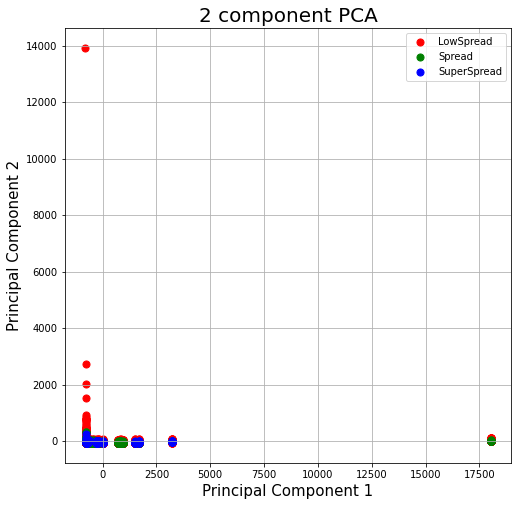

In [79]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LowSpread', 'Spread', 'SuperSpread']
targets2 = np.unique(y_train)
colors = ['r', 'g', 'b']
for target, color in zip(targets2,colors):
    print(target)
    indicesToKeep = finalDf['label_code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [80]:
#obtain the eigenpairs of the Wine covariance matrix:
#data_cov = np.dot(np.transpose(data.values),data.values)
#data_cov
X_train_cov = np.cov(X_train_std.T)
w, v = np.linalg.eig(X_train_cov)

In [81]:
#The percent of variability contained within each component
w_percent = (w/np.sum(w))*100                 
print(w, '-> eigenvalues')
print(w_percent, ' -> percent of variability explained')

[4.68190471 1.74653449 1.46032377 0.80300952 0.64539697 0.54509859
 0.37669832 0.0825042  0.27613096 0.23293532 0.15117495] -> eigenvalues
[42.55614759 15.87511586 13.27360507  7.29895067  5.86633225  4.95467068
  3.42399731  0.74992146  2.50989083  2.11726438  1.37410389]  -> percent of variability explained


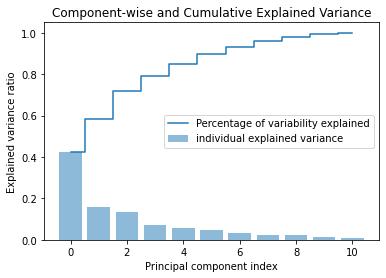

In [82]:
# calculate cumulative sum of explained variances
tot = sum(w)
var_exp = [(i / tot) for i in sorted(w, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.title("Component-wise and Cumulative Explained Variance")
plt.bar(range(0,11), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(0,11), cum_var_exp, where='mid',
         label='Percentage of variability explained')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [83]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(w[i]), v[:, i]) for i in range(len(w))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w2 = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W2:\n', w2)

Matrix W2:
 [[ 0.39802686  0.07548609]
 [ 0.36806604  0.09620801]
 [ 0.21207444  0.10891566]
 [ 0.37897478  0.08480521]
 [ 0.34828846  0.07030567]
 [-0.39530182 -0.08205423]
 [ 0.33752331  0.0546998 ]
 [ 0.20123608 -0.66139603]
 [ 0.1330275  -0.7067886 ]
 [-0.21066697 -0.08990957]
 [ 0.15310568  0.07902472]]


In [84]:
X_train_pca = X_train_std.dot(w2)
print(X_train_pca)

[[ 1.02907231  0.50060721]
 [-1.17610228 -0.16989335]
 [ 2.36704187 -0.15435181]
 ...
 [-1.95580732 -0.42506671]
 [-1.43175017  0.1959066 ]
 [-0.56951383 -0.15928261]]


In [85]:
np.unique(y_train)
X_train_pca

array([[ 1.02907231,  0.50060721],
       [-1.17610228, -0.16989335],
       [ 2.36704187, -0.15435181],
       ...,
       [-1.95580732, -0.42506671],
       [-1.43175017,  0.1959066 ],
       [-0.56951383, -0.15928261]])

# 2.Load data - Maryland Inertia Data

In [86]:
CA_inertia_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA_sd_inertia_labeledData_Sep14.csv',low_memory=False)
print(CA_inertia_labeled_data.shape)

(12296, 56)


In [87]:
CA_inertia_labeled_data.dtypes

Date                                           object
Province_State                                 object
FIPS                                            int64
New cases                                       int64
mask_rule_active                                int64
CTFIPS                                          int64
CTNAME                                         object
STFIPS                                          int64
Social distancing index                         int64
% staying home                                  int64
Trips/person                                  float64
% out-of-county trips                         float64
% out-of-state trips                          float64
Miles/person                                  float64
Work trips/person                             float64
Non-work trips/person                         float64
New COVID cases                                 int64
Population                                      int64
% change in consumption     

## Preprocessing data 

* drop na
* convert categorical code

In [88]:
CA_inertia_labeled_data['label_code'] = CA_inertia_labeled_data['label'].astype('category').cat.codes

CA_inertia_labeled_data.head(2)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label,label_code
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0
1,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0


In [89]:
CA_inertia_labeled_data = CA_inertia_labeled_data.dropna()

In [90]:
CA_inertia_labeled_data[pd.isna(CA_inertia_labeled_data['label'])]

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label,label_code


In [91]:
CA_inertia_labeled_data['label_code'].unique()

array([0, 1, 7, 2, 3, 4, 5, 6], dtype=int8)

In [92]:
CA_inertia_labeled_data['growth_code'] = CA_inertia_labeled_data['growth_label'].astype('category').cat.codes
CA_inertia_labeled_data.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,growth_label,label_code,growth_code
0,2020-01-22,California,6001,0,0,6001,Alameda County,6,18,20,3.29,29.4,0.3,35.9,0.55,2.74,0,1666753,-2.9,2020-01-22,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,2
1,2020-01-22,California,6041,0,0,6041,Marin County,6,15,20,3.42,27.8,0.1,42.3,0.52,2.90,0,259666,2.5,2020-01-22,9.51,28,110217,2.2,15.9,48.83,314,308,218,2.05,0.22,0.0,0.0,73,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,2
2,2020-01-22,California,6039,0,0,6039,Madera County,6,18,17,3.55,29.7,0.1,39.9,0.52,3.03,0,157672,1.5,2020-01-22,0.45,19,52884,3.1,57.3,48.18,72,29,81,2.05,0.22,0.0,0.0,12,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,2
3,2020-01-22,California,6103,0,0,6103,Tehama County,6,18,19,3.47,30.1,1.9,50.6,0.55,2.93,0,63916,5.1,2020-01-22,0.33,26,42899,0.7,24.7,49.71,21,6,106,2.05,0.22,0.0,0.0,59,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,2
4,2020-01-22,California,6037,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,1.2,3.9,5.7,0.3,54.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LessSpread,flat_growth,0,2


In [93]:
CA_inertia_labeled_data['growth_code'].unique()

array([2, 3, 4, 0, 1], dtype=int8)

In [94]:
CA_inertia_labeled_data.dtypes

Date                                           object
Province_State                                 object
FIPS                                            int64
New cases                                       int64
mask_rule_active                                int64
CTFIPS                                          int64
CTNAME                                         object
STFIPS                                          int64
Social distancing index                         int64
% staying home                                  int64
Trips/person                                  float64
% out-of-county trips                         float64
% out-of-state trips                          float64
Miles/person                                  float64
Work trips/person                             float64
Non-work trips/person                         float64
New COVID cases                                 int64
Population                                      int64
% change in consumption     

In [95]:
CA_inertia_labeled_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'mask_rule_active',
       'CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate',
       '% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity',
   

In [96]:
feature_labels = ['mask_rule_active','Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person','Non-work trips/person','% change in consumption',
       'Transit mode share','% people older than 60', 'Median income', '% African Americans', '% Hispanic Americans',
       '% Male', 'Population density','Employment density', '# hot spots/1000 people','Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people rank','% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate','% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity','Tests done/1000 people', '% ICU utilization', 'Ventilator shortage'
       ]

target_column = ['label_code']

X = CA_inertia_labeled_data[feature_labels]
y = CA_inertia_labeled_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


## Train Random Forest classifier

In [97]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


('mask_rule_active', 0.004816666537664439)
('Social distancing index', 0.019852753081058543)
('% staying home', 0.018758588717157694)
('Trips/person', 0.02035465261146869)
('% out-of-county trips', 0.04269254445155563)
('% out-of-state trips', 0.03076218012081099)
('Miles/person', 0.029621030711936662)
('Work trips/person', 0.02175883499554746)
('Non-work trips/person', 0.02070080421822134)
('% change in consumption', 0.021179553919735365)
('Transit mode share', 0.04461027197002454)
('% people older than 60', 0.038133214232357555)
('Median income', 0.045573647187780855)
('% African Americans', 0.034127049867349775)
('% Hispanic Americans', 0.05042938926089247)
('% Male', 0.05370803883745204)
('Population density', 0.05094197910022197)
('Employment density', 0.05039955157867229)
('# hot spots/1000 people', 0.03729453508117096)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.038226006259660

In [98]:

#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.005657067646954907)
('Social distancing index', 0.012866232804764326)
('% staying home', 0.012486939452518414)
('Trips/person', 0.012863246415679189)
('% out-of-county trips', 0.037838468022148804)
('% out-of-state trips', 0.028988610631632755)
('Miles/person', 0.022566240455596586)
('Work trips/person', 0.014620701399038366)
('Non-work trips/person', 0.013995971284024179)
('% change in consumption', 0.014883074043638572)
('Transit mode share', 0.04889163204989308)
('% people older than 60', 0.035396840411933576)
('Median income', 0.0463769065889474)
('% African Americans', 0.03461969911790896)
('% Hispanic Americans', 0.04654329406737775)
('% Male', 0.05298464196137698)
('Population density', 0.054271591641386)
('Employment density', 0.05435839671708884)
('# hot spots/1000 people', 0.035672451268136535)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.03570779601403

## PCA Computation

In [99]:
print(len(feature_labels))

33


In [100]:
# split into training and testing datasets


X = CA_inertia_labeled_data[feature_labels].values
y = CA_inertia_labeled_data[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=0)
print(X_train)
print(y_train)

[[  0.    27.    19.   ...   0.     0.     0.  ]
 [  0.    76.    54.   ...  13.3   16.89 659.  ]
 [  0.    26.    21.   ...   0.     0.     0.  ]
 ...
 [  1.    42.    30.   ... 136.68  23.17 713.  ]
 [  0.    17.    21.   ...   0.     0.     0.  ]
 [  1.    46.    32.   ... 158.93  24.17 687.  ]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [101]:
# standardize the features
sc = ss()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [102]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [103]:
principalDf

,principal component 1,principal component 2
0,28227.531076,1059.775993
1,45810.582949,-1315.263783
2,-11509.661091,-53.495323
3,-21492.257250,172.009591
4,-84.004179,1862.588838
...,...,...
12277,-443.012827,-116.837497
12278,-11125.661486,-132.188116
12279,19956.236012,-750.979615
12280,20350.318313,-824.602067


In [104]:
finalDf = pd.concat([principalDf, CA_inertia_labeled_data[target_column]],axis=1 )
finalDf

,principal component 1,principal component 2,label_code
0,28227.531076,1059.775993,0.0
1,45810.582949,-1315.263783,0.0
2,-11509.661091,-53.495323,0.0
3,-21492.257250,172.009591,0.0
4,-84.004179,1862.588838,0.0
...,...,...,...
12291,NaN,NaN,0.0
12292,NaN,NaN,0.0
12293,NaN,NaN,0.0
12294,NaN,NaN,0.0


0
1
2


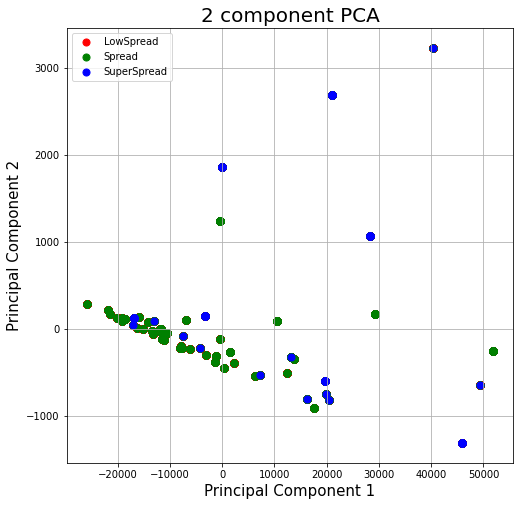

In [105]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LowSpread', 'Spread', 'SuperSpread']
targets2 = np.unique(y_train)
colors = ['r', 'g', 'b']
for target, color in zip(targets2,colors):
    print(target)
    indicesToKeep = finalDf['label_code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [106]:
#obtain the eigenpairs of the Wine covariance matrix:
#data_cov = np.dot(np.transpose(data.values),data.values)
#data_cov
X_train_cov = np.cov(X_train_std.T)
w, v = np.linalg.eig(X_train_cov)

In [107]:
#The percent of variability contained within each component
w_percent = (w/np.sum(w))*100                 
print(w, '-> eigenvalues')
print(w_percent, ' -> percent of variability explained')

[6.78176255e+00 5.81147821e+00 4.16384432e+00 3.04806392e+00
 1.61826953e+00 1.53809764e+00 1.16678825e+00 1.03959136e+00
 7.01948622e-01 6.27560291e-01 5.77938323e-01 5.09886864e-01
 4.47042622e-01 4.15067882e-01 3.45739855e-01 2.85653193e-01
 1.96523613e-01 1.85829164e-01 1.29835576e-01 1.06867368e-01
 8.34215634e-02 7.09720536e-02 5.43499428e-02 3.28227437e-02
 2.40888600e-02 1.70102373e-02 3.68163929e-03 8.70515511e-03
 1.05842525e-02 6.43972019e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00] -> eigenvalues
[2.26032456e+01 1.93693407e+01 1.38778666e+01 1.01590312e+01
 5.39360430e+00 5.12639577e+00 3.88884177e+00 3.46490145e+00
 2.33955657e+00 2.09162431e+00 1.92623699e+00 1.69942518e+00
 1.48996874e+00 1.38339867e+00 1.15233213e+00 9.52066553e-01
 6.55002512e-01 6.19358496e-01 4.32734912e-01 3.56183124e-01
 2.78039533e-01 2.36545994e-01 1.81145403e-01 1.09396419e-01
 8.02868599e-02 5.66941956e-02 1.22707035e-02 2.90138084e-02
 3.52767379e-02 2.14632371e-04 0.00000000e+00 0.00000

ValueError: ignored

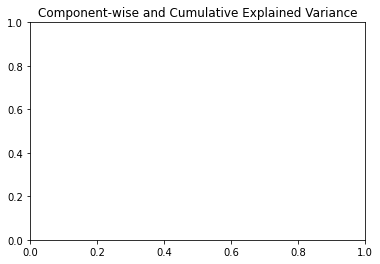

In [108]:
# calculate cumulative sum of explained variances
tot = sum(w)
var_exp = [(i / tot) for i in sorted(w, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.title("Component-wise and Cumulative Explained Variance")
plt.bar(range(0,11), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(0,11), cum_var_exp, where='mid',
         label='Percentage of variability explained')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [109]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(w[i]), v[:, i]) for i in range(len(w))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w2 = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W2:\n', w2)

Matrix W2:
 [[ 0.1940274  -0.25832046]
 [ 0.26011632  0.26166054]
 [ 0.25422975  0.25760311]
 [-0.24124271 -0.24238762]
 [ 0.02797483 -0.06938934]
 [ 0.03055397 -0.02468673]
 [-0.0547733  -0.25959361]
 [-0.23234014 -0.01513562]
 [-0.18816255 -0.27463045]
 [-0.17553431 -0.27308295]
 [ 0.0941035   0.16884234]
 [ 0.01021858 -0.05188179]
 [ 0.08916532  0.1617789 ]
 [ 0.02169667  0.07417045]
 [-0.04325632 -0.01819944]
 [-0.01011117 -0.03872893]
 [ 0.08951304  0.18288666]
 [ 0.09490567  0.18716268]
 [ 0.07370409  0.06903931]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.0070063  -0.05711857]
 [ 0.21671138 -0.28188022]
 [ 0.19539664  0.13786314]
 [ 0.28912273 -0.17435323]
 [ 0.32316934 -0.03909143]
 [-0.0241219  -0.11691411]
 [ 0.28450228 -0.20359022]
 [ 0.12741292  0.13127208]
 [ 0.22353917 -0.29000211]
 [ 0.30586772 -0.20034417]
 [ 0.30105583 -0.22014764]]


In [110]:
X_train_pca = X_train_std.dot(w2)
print(X_train_pca)

[[-4.00499076 -0.1138379 ]
 [ 5.90065956  7.65371342]
 [-3.84548918 -0.15591668]
 ...
 [ 2.58508625 -0.80861393]
 [-4.51633132 -0.11895685]
 [ 3.05058021 -0.40310776]]


In [111]:
np.unique(y_train)
X_train_pca

array([[-4.00499076, -0.1138379 ],
       [ 5.90065956,  7.65371342],
       [-3.84548918, -0.15591668],
       ...,
       [ 2.58508625, -0.80861393],
       [-4.51633132, -0.11895685],
       [ 3.05058021, -0.40310776]])